# Article Page Dataset Assembly and Basic Visual Analysis

This notebook provides the code that was used to assemble the monthly datasets and basic visual analysis performed on the Wikimedia rare diseases pages.

## Import Necessary Packages
For making the API calls, we import `request`. For handling the jsons and converting them to dataframes we use `Polars` and for plotting we use `Matplotlib`.

In [1]:
# Imports
import json, time, urllib.parse
import requests
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

## Constants
For making the API calls more readable, we utilize a modified version of the example code provided by Dr. David W. McDonald.
The main modifications are changes to the request header and to the access, start, and end parameters.

In [2]:
# Constants
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<tliu2@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types -> edit: add parameter to request pageviews function for changing access
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",   # start and end dates need to be set -> edit: set the start date to 01/01/2015
    "end":         "2024093000"    # this is likely the wrong end date -> edit: set the end date to 09/30/2024
}

## Functions
For actually acquiring the data and assembling the datasets, we define the following functions.
The function `request_pageviews_per_article` is a slighly modified version of the example function provided by Dr. David W. McDonald.
The only change is the addition of the access parameter. 


In [3]:
# Functions
def request_pageviews_per_article(article_title = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS,
                                  access = 'desktop'):  # Add access parameter

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # type of access change
    if access:
        request_template['access'] = access

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    # Add safe param to deal with slashes in article titles.
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


def process_json(record):
    """
    Given a record from the wikimedia api, extract the data and store it into a dataframe such that
    each item is a column (e.g. article, views, et.c)
    :param record: record from the api.
    :return: Dataframe of the output
    """

    # Get the data via the "items" key.
    items = record.get('items', [])
    if not items:
        print('Invalid Article')
        return pl.DataFrame()

    df = pl.from_records(items)
    df = df.drop('access')
    return df

def create_combined(mobile_web_data: pl.DataFrame, mobile_app_data: pl.DataFrame, desktop_data: pl.DataFrame):
    """
    Given dataframes of data for the mobile and desktop data, merge them to create the combined mobile and cumulative dataframes.
    :param mobile_web_data: Dataframe containing the mobile web data.
    :param mobile_app_data: Dataframe containing the mobile app data.
    :param desktop_data: Dataframe containing the desktop data.
    :return: Dataframes containing the combined mobile data and the cumulative data.
    """

    mobile_res = pl.concat([mobile_web_data, mobile_app_data])
    cumulative_res = pl.concat([mobile_res, desktop_data])
    
    # Mobile data has was divided into access types of mobile-web and mobile-app. We don't care about that so sum together
    # data that fall on the same timestamp for a given article.
    mobile_res = mobile_res.group_by(['project', 'article', 'granularity', 'timestamp', 'agent']).agg(
        pl.col('views').sum().alias('views')
    )
    # Same as above but we don't care about distinguishing between desktop and mobile in cumulative set.
    cumulative_res = cumulative_res.group_by(['project', 'article', 'granularity', 'timestamp', 'agent']).agg(
        pl.col('views').sum().alias('views')
    )

    return mobile_res, cumulative_res

def create_json(df: pl.DataFrame):
    """
    Taking a dataframe form of the API data, convert it to the desired json format.
    :param df: Dataframe containing the API data.
    :return: Dictionary of the data in the specified json format.
    """
    d = {}
    for article, other in df.group_by(['article'], maintain_order=True):
        article = article[0]
        d[article] = other.to_dicts()
    return d

def assemble_article_sets(article_list: list):
    """
    Takes in a list of article titles to request from the API.
    :param article_list: List of article titles.
    :return: None
    """

    desktop_df, mobile_app_df, mobile_web_df = pl.DataFrame(), pl.DataFrame(), pl.DataFrame()
    total_articles = len(article_list)
    counter = 1
    for article in article_list:
        print(f'At article: {article}, {counter} / {total_articles} articles.')
        # Request the API for page by access for the given article
        views_desktop = request_pageviews_per_article(article_title=article, access='desktop')
        views_mobile_app = request_pageviews_per_article(article_title=article, access='mobile-app')
        views_mobile_web = request_pageviews_per_article(article_title=article, access='mobile-web')

        desktop_res = process_json(record=views_desktop)
        mobile_app_res = process_json(record=views_mobile_app)
        mobile_web_res = process_json(record=views_mobile_web)
        try:
            desktop_df = pl.concat([desktop_df, desktop_res])
            mobile_app_df = pl.concat([mobile_app_df, mobile_app_res])
            mobile_web_df = pl.concat([mobile_web_df, mobile_web_res])
        except pl.exceptions.ShapeError:
            pass

        counter += 1


    mobile_df, cumulative_df = create_combined(mobile_web_data=mobile_web_df, mobile_app_data=mobile_app_df, desktop_data=desktop_df)

    desktop_json = create_json(df=desktop_df)
    mobile_json = create_json(df=mobile_df)
    cumulative_json = create_json(df=cumulative_df)

    output_paths = [
        Path(f'./rare-disease_monthly_desktop_{ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["start"]}-{ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["end"]}.json'),
        Path(f'./rare-disease_monthly_mobile_{ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["start"]}-{ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["end"]}.json'),
        Path(f'./rare-disease_monthly_cumulative_{ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["start"]}-{ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["end"]}.json')
    ]
    jsons = [desktop_json, mobile_json, cumulative_json]
    for output_path, json_file in zip(output_paths, jsons):
        with open(output_path, 'w', encoding='utf-8') as output:
            json.dump(json_file, output, indent=4)



def read_json(path: Path):
    """
    Function to read in the produced data sets.
    :param path: Path variable containing the path to the json to be read in.
    :return: Polars dataframe
    """
    with open(path, 'r') as file:
        data = json.load(file)

    records = []
    for article, views in data.items():
        for view in views:
            view['article'] = article
            records.append(view)

    df = pl.DataFrame(records)
    return df
        

## Assembling the Datasets
With our functions defined, we move onto assembling the datasets.
Per the specifications, we are to create three datasets:
1. Monthly mobile access set.
2. Monthly desktop access set.
3. Monthly cumulative access set - which incorporates both mobile access and desktop access data.

First, we need to read in the csv containing the articles we want and convert it to a list which we can pass to our function to make the
API calls and assemble the 3 datasets.

In [27]:
rare_diseases = pl.read_csv('./rare-disease_cleaned.AUG.2024.csv')
article_list = rare_diseases.select('disease').to_series().to_list()

# Assembles the 3 datasets and writes them to json.
assemble_article_sets(article_list=article_list)


At article: Klinefelter syndrome, 1 / 1773 articles.
At article: Aarskog–Scott syndrome, 2 / 1773 articles.
At article: Abetalipoproteinemia, 3 / 1773 articles.
At article: MT-TP, 4 / 1773 articles.
At article: Ablepharon macrostomia syndrome, 5 / 1773 articles.
At article: Acanthocheilonemiasis, 6 / 1773 articles.
At article: Acanthosis nigricans, 7 / 1773 articles.
At article: Aceruloplasminemia, 8 / 1773 articles.
At article: Megaesophagus, 9 / 1773 articles.
At article: Achard–Thiers syndrome, 10 / 1773 articles.
At article: Achondrogenesis, 11 / 1773 articles.
At article: Achondroplasia, 12 / 1773 articles.
At article: Dwarfism, 13 / 1773 articles.
At article: Osteochondrodysplasia, 14 / 1773 articles.
At article: Fibroblast growth factor receptor 3, 15 / 1773 articles.
At article: Vestibular schwannoma, 16 / 1773 articles.
At article: Brain tumor, 17 / 1773 articles.
At article: Acquired generalized lipodystrophy, 18 / 1773 articles.
At article: Barraquer–Simons syndrome, 19 / 17

## Analysis - Preprocessing

Now that we have the datasets formed, we can begin our analysis. We first need to read in the data to analyze our three points:
1. The highest and lowest average page requests for an article grouped by the access type.
2. The 10 articles with the highest peak page views over the entire time series by access type.
3. The articles that have the fewest months of data.

However, we need to do some preprocessing before we can address these points.
We'll first create a dataframe that's contain the average page views per access type and article.
Then we'll create another dataframe that contains the peak page views for each article.
Finally, we'll then create the last dataframe which will contain the articles with lowest number of data points.

We first load in the json files that we created.
Since we want to compare some of the page view data by access type, we'll add a column `access` to the mobile data and desktop data.

In [4]:
# Since all objectives require all access types, we read in the cumulative data.
cumulative_data = read_json(path=Path('./rare-disease_monthly_cumulative_2015010100-2024093000.json'))
mobile_data = read_json(path=Path('./rare-disease_monthly_mobile_2015010100-2024093000.json'))
desktop_data = read_json(path=Path('./rare-disease_monthly_desktop_2015010100-2024093000.json'))

# Add our own access column
mobile_data = mobile_data.with_columns(
    access=pl.lit('mobile')
)
desktop_data = desktop_data.with_columns(
    access=pl.lit('desktop')
)

print(mobile_data.head(n=5))

shape: (5, 7)
┌──────────────┬──────────────┬─────────────┬────────────┬───────┬───────┬────────┐
│ project      ┆ article      ┆ granularity ┆ timestamp  ┆ agent ┆ views ┆ access │
│ ---          ┆ ---          ┆ ---         ┆ ---        ┆ ---   ┆ ---   ┆ ---    │
│ str          ┆ str          ┆ str         ┆ str        ┆ str   ┆ i64   ┆ str    │
╞══════════════╪══════════════╪═════════════╪════════════╪═══════╪═══════╪════════╡
│ en.wikipedia ┆ XYY_syndrome ┆ monthly     ┆ 2016020100 ┆ user  ┆ 22252 ┆ mobile │
│ en.wikipedia ┆ XYY_syndrome ┆ monthly     ┆ 2016030100 ┆ user  ┆ 21516 ┆ mobile │
│ en.wikipedia ┆ XYY_syndrome ┆ monthly     ┆ 2018030100 ┆ user  ┆ 23903 ┆ mobile │
│ en.wikipedia ┆ XYY_syndrome ┆ monthly     ┆ 2022050100 ┆ user  ┆ 12015 ┆ mobile │
│ en.wikipedia ┆ XYY_syndrome ┆ monthly     ┆ 2022080100 ┆ user  ┆ 13232 ┆ mobile │
└──────────────┴──────────────┴─────────────┴────────────┴───────┴───────┴────────┘


Now that we can differentiate our mobile and desktop data, we'll concatenate them into a single dataframe.


In [5]:
# Create concatenated dataframe of mobile and desktop data.
concat_df = pl.concat([mobile_data, desktop_data])

We'll also convert the timestamp column to a datetime in all our dataframes.

In [6]:
# Convert the timestamp to datetime
cumulative_data = cumulative_data.with_columns(
    pl.col('timestamp').str.strptime(pl.Datetime('ns'), format='%Y%M%d%H', strict=True)
)
concat_df = concat_df.with_columns(
    pl.col('timestamp').str.strptime(pl.Datetime('ns'), format='%Y%M%d%H', strict=True)
)

# For illustrative purposes lets sort on article and timestamp and print
concat_df = concat_df.sort(['article', 'timestamp'])
# concat_df = concat_df.filter(pl.col('timestamp') >= pl.datetime(2024, 1, 1) )

print(concat_df.head(n=5))


shape: (5, 7)
┌──────────────┬─────────┬─────────────┬─────────────────────┬───────┬───────┬─────────┐
│ project      ┆ article ┆ granularity ┆ timestamp           ┆ agent ┆ views ┆ access  │
│ ---          ┆ ---     ┆ ---         ┆ ---                 ┆ ---   ┆ ---   ┆ ---     │
│ str          ┆ str     ┆ str         ┆ datetime[ns]        ┆ str   ┆ i64   ┆ str     │
╞══════════════╪═════════╪═════════════╪═════════════════════╪═══════╪═══════╪═════════╡
│ en.wikipedia ┆ 18p     ┆ monthly     ┆ 2015-01-01 00:07:00 ┆ user  ┆ 22    ┆ desktop │
│ en.wikipedia ┆ 18p     ┆ monthly     ┆ 2015-01-01 00:07:00 ┆ user  ┆ 2     ┆ mobile  │
│ en.wikipedia ┆ 18p     ┆ monthly     ┆ 2015-01-01 00:08:00 ┆ user  ┆ 1     ┆ mobile  │
│ en.wikipedia ┆ 18p     ┆ monthly     ┆ 2015-01-01 00:08:00 ┆ user  ┆ 13    ┆ desktop │
│ en.wikipedia ┆ 18p     ┆ monthly     ┆ 2015-01-01 00:09:00 ┆ user  ┆ 12    ┆ desktop │
└──────────────┴─────────┴─────────────┴─────────────────────┴───────┴───────┴─────────┘


Now we create the dataframe that will have the average views for an article per access type.

In [7]:
# Group by the article and access and average over the views. For displaying purposes, we then sort on the average views.
avg_df = concat_df.group_by(['article', 'access']).agg(
    pl.col('views').mean().alias('average_views')
).sort(by='average_views', descending=True)
print(avg_df.filter(pl.col('access') == 'mobile').head(n=5))
print(avg_df.filter(pl.col('access') == 'desktop').head(n=5))

print(avg_df.sort(by='average_views').head(n=5))

shape: (5, 3)
┌───────────────────────────────┬────────┬───────────────┐
│ article                       ┆ access ┆ average_views │
│ ---                           ┆ ---    ┆ ---           │
│ str                           ┆ str    ┆ f64           │
╞═══════════════════════════════╪════════╪═══════════════╡
│ Black_Death                   ┆ mobile ┆ 177697.846847 │
│ Tuberculosis                  ┆ mobile ┆ 155546.099099 │
│ Multiple_sclerosis            ┆ mobile ┆ 122010.297297 │
│ Amyotrophic_lateral_sclerosis ┆ mobile ┆ 101279.243243 │
│ Leprosy                       ┆ mobile ┆ 94630.018018  │
└───────────────────────────────┴────────┴───────────────┘
shape: (5, 3)
┌────────────────────┬─────────┬───────────────┐
│ article            ┆ access  ┆ average_views │
│ ---                ┆ ---     ┆ ---           │
│ str                ┆ str     ┆ f64           │
╞════════════════════╪═════════╪═══════════════╡
│ Black_Death        ┆ desktop ┆ 104859.315315 │
│ Tuberculosis       ┆ deskto

We can see that it the Black_Death has the highest average page views in both desktop and mobile categories, and that Filippi_Syndrome has the lowest average views for both access types.

Now we create the dataframe that contains the peak views of an article per month by access type.
The specification describes this process as finding the month for each article that contains the greatest page views and the ordering them by the views.

In [8]:
# Create a column representing the month and year, then group by the article, month, year, and access and get the max (peak) view.
peak_df = concat_df.with_columns(
    pl.col('timestamp').dt.strftime('%m-%Y').alias('month_year')
).group_by(['article', 'month_year', 'access']).agg(
    pl.col('views').max().alias('peak_views')
).sort(by='peak_views', descending=True)

print(peak_df.head(n=5))

shape: (5, 4)
┌───────────────────┬────────────┬─────────┬────────────┐
│ article           ┆ month_year ┆ access  ┆ peak_views │
│ ---               ┆ ---        ┆ ---     ┆ ---        │
│ str               ┆ str        ┆ str     ┆ i64        │
╞═══════════════════╪════════════╪═════════╪════════════╡
│ Black_Death       ┆ 01-2020    ┆ mobile  ┆ 2313741    │
│ Pandemic          ┆ 01-2020    ┆ mobile  ┆ 2276916    │
│ Pandemic          ┆ 01-2020    ┆ desktop ┆ 1046521    │
│ Black_Death       ┆ 01-2020    ┆ desktop ┆ 823649     │
│ Pfeiffer_syndrome ┆ 01-2016    ┆ mobile  ┆ 777886     │
└───────────────────┴────────────┴─────────┴────────────┘


## Analysis - Plotting

Now that we have the dataframes set up, we can begin plotting.
We'll create three plots:
1. Maximum Average and Minimum Average
    - Article pages with the highest and lowest page requests for desktop and mobile access.
2. Top 10 Peak Page Views 
    - Article pages with the largest peak page views over the entire time series by access type.
3. Fewest Months of Data 
    - Article pages that have the fewest months of data.

First lets define a plot style - in our case we'll use ggplot styling.

In [9]:
plt.style.use('ggplot')

### Maximum Average and Minimum Average
We first plot the page view data of articles that had the maximum and minimum average page views over the entire time series.

First we begin by identifying the articles which have the highest and lowest average views. We utilize our previously defined `avg_df` which contains average views of each article by access type over the entire time series.
For acquiring the maximum, we sort in descending order on average views such that the article with the maximum average views is at the top of our dataframe. Then we simply grab the article name at the top.
For acquiring the minimum, we perform the same operation but instead of sorting in descending order, we sort in ascending order.

Once we have these articles corresponding to maximum and minimum average views for both access types, we can filter our time series data for these articles.

In [10]:
# Find the articles with the max average views and min averages views by access type.
desktop_avg = avg_df.filter(pl.col('access') == 'desktop')
max_desktop_article = desktop_avg.sort(by='average_views', descending=True).select('article').to_series()[0]
min_desktop_article = desktop_avg.sort(by='average_views').select('article').to_series()[0]

mobile_avg = avg_df.filter(pl.col('access') == 'mobile')

max_mobile_article = mobile_avg.sort(by='average_views', descending=True).select('article').to_series()[0]
min_mobile_article = mobile_avg.sort(by='average_views').select('article').to_series()[0]

# Filter down the overall time series data for the respective articles.
max_desktop = concat_df.filter(
    (pl.col('article') == max_desktop_article) & (pl.col('access') == 'desktop')
).sort(by='timestamp')
min_desktop = concat_df.filter(
    (pl.col('article') == min_desktop_article) & (pl.col('access') == 'desktop')
).sort(by='timestamp')

max_mobile = concat_df.filter(
    (pl.col('article') == max_mobile_article) & (pl.col('access') == 'mobile')
).sort(by='timestamp')
min_mobile = concat_df.filter(
    (pl.col('article') == min_mobile_article) & (pl.col('access') == 'mobile')
).sort(by='timestamp')


max_desktop.write_csv('test_desktop.csv')
max_mobile.write_csv('test_mobile.csv')

min_desktop.write_csv('test_min_desktop.csv')
min_mobile.write_csv('test_min_mobile.csv')


With our dataframes set up representing the articles that have the maximum and minimum average views over the entire time series acquired, we can begin plotting.

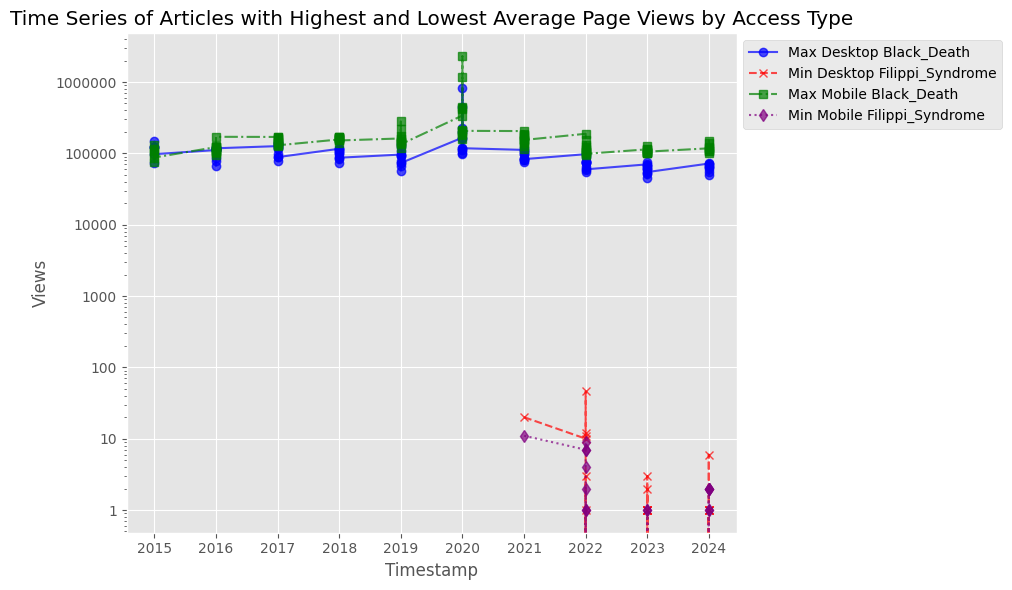

In [11]:
# Plot the data.
# Create subplots.
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(
    max_desktop.select('timestamp'), max_desktop.select('views'),
    label=f'Max Desktop {max_desktop_article}',
    color='blue', linestyle='-', marker='o', alpha=0.7,
)

ax.plot(
    min_desktop.select('timestamp'), min_desktop.select('views'),
    label=f'Min Desktop {min_desktop_article}', 
    color='red', linestyle='--', marker='x', alpha=0.7,
)

ax.plot(
    max_mobile.select('timestamp'), max_mobile.select('views'),
    label=f'Max Mobile {max_mobile_article}',
    color='green', linestyle='-.', marker='s', alpha=0.7,
)

ax.plot(
    min_mobile.select('timestamp'), min_mobile.select('views'),
    label=f'Min Mobile {min_mobile_article}',
    color='purple', linestyle=':', marker='d', alpha=0.7,
)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Views')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.set_yscale('log')  # set the y-axis to log scale to better visualize both max and min data.

# Remove the scientific notation y-axis.
ax.get_yaxis().set_major_formatter(mticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='y')



ax.set_title('Time Series of Articles with Highest and Lowest Average Page Views by Access Type')
fig.tight_layout()
fig.savefig('max_min_avg_views_articles.png')

plt.show()

### Top 10 Peak Page Views 
Next, we will plot the time series data for the top 10 articles that had the largest peak over the entire time series. In other words, the 10 articles that had the highest views at any point in time.
We'll accomplish this by using our previously defined `peak_df` which calculated, for each article, month, and access type, the greatest peak in views.

Using the identified top 10 articles from `peak_df`, we can subset out overall time series data for the articles we identified for each access type.


In [12]:
# Get the article that corresponds to the max and min views by access
desktop_peak = peak_df.filter(pl.col('access') == 'desktop')
mobile_peak = peak_df.filter(pl.col('access') == 'mobile')

top10_desktop_article = desktop_peak.sort(by='peak_views', descending=True).head(10).select('article').to_series().to_list()
top10_mobile_article = mobile_peak.sort(by='peak_views', descending=True).head(10).select('article').to_series().to_list()

# In the overall time series data, filter for the top 10 articles in each access type.
top10_desktop_df = concat_df.filter(
    pl.col('article').is_in(top10_desktop_article)
)
top10_mobile_df = concat_df.filter(
    pl.col('article').is_in(top10_mobile_article)
)

top10_mobile_df.write_csv('top10mobile.csv')
top10_desktop_df.write_csv('top10desktop.csv')


With our top 10 articles from each access type, we move onto actual plotting.

To plot all our articles, we'll iterate through our list of top 10 for each access type and then plot the time series for that article.

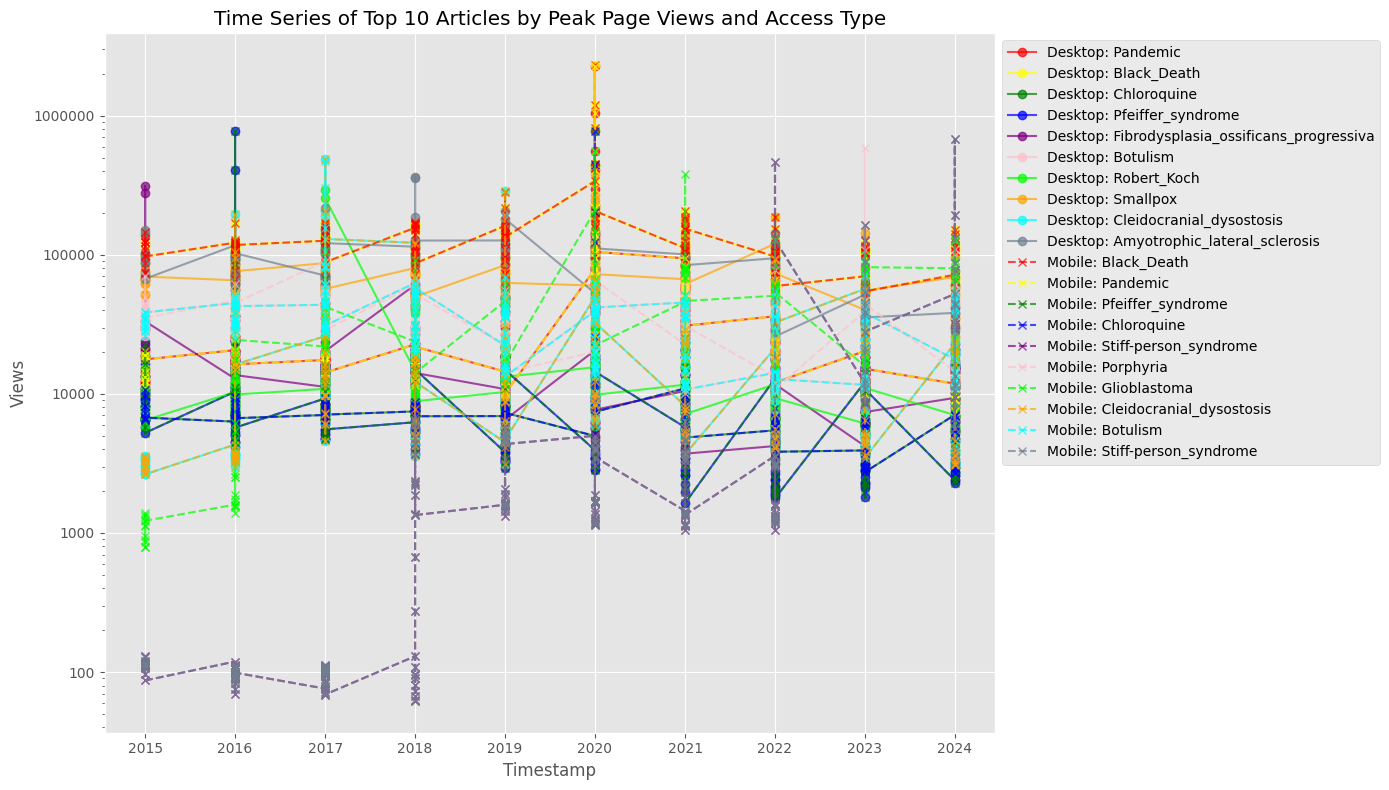

In [13]:
# Plot the data

fig, ax = plt.subplots(figsize=(14, 8))
# Define a bunch of colors for use in plotting to differentiate lines.
colors = [
    'red', 'yellow', 'green', 'blue', 'purple', 'pink', 'lime', 'orange', 'cyan', 'slategray',
]
# First subplot (Desktop)
for idx, article in enumerate(top10_desktop_article):
    article_df = top10_desktop_df.filter(pl.col('article') == article)
    ax.plot(
        article_df.select('timestamp'),
        article_df.select('views'),
        label=f'Desktop: {article}',
        linestyle='-',
        marker='o',
        alpha=0.7,
        color=colors[idx % len(colors)]
    )

# Second subplot (Mobile)
for idx, article in enumerate(top10_mobile_article):
    article_df = top10_mobile_df.filter(pl.col('article') == article)
    ax.plot(
        article_df.select('timestamp'),
        article_df.select('views'),
        label=f'Mobile: {article}',
        linestyle='--',
        marker='x',
        alpha=0.7,
        color=colors[idx % len(colors)]
    )


ax.set_title('Time Series of Top 10 Articles by Peak Page Views and Access Type')
ax.set_xlabel('Timestamp')
ax.set_yscale('log')  # set the y-axis to log scale to better visualize wide range of views data.
ax.set_ylabel('Views')
ax.legend()
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

# Remove the scientific notation y-axis.
ax.get_yaxis().set_major_formatter(mticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='y')


fig.tight_layout()
fig.savefig('top10_articles_peak_views.png')

plt.show()

### Fewest Months of Data 
Lastly, we'll plot time series data on the articles which have the fewest months of data by access type.
To do this, we'll count the number of months each article has by defining a month variable which is truncation of the timestamp variable.
This means that a timestamp that looks like `2024-01-01 00:22:00` becomes `2024-01-01 00:00:00`.

We then group by the article and access type and count the number of unique months are present for each article by access type and store this count in a new variable `num_months`.
With `num_months`, we then do an ascending sort and take the top 10 articles for each access type to get the 10 articles (as defined in the specification) with the fewest months of data.

With the top 10 articles that have the fewest months of data defined, we can then filter down the overall time series data for these articles by access type.


In [14]:
# Truncate the timestamp to create new month column
months_per_article = concat_df.with_columns(
    pl.col('timestamp').dt.truncate('1mo').alias('month')
)

print(months_per_article.head(n=5))

shape: (5, 8)
┌──────────────┬─────────┬─────────────┬────────────────┬───────┬───────┬─────────┬────────────────┐
│ project      ┆ article ┆ granularity ┆ timestamp      ┆ agent ┆ views ┆ access  ┆ month          │
│ ---          ┆ ---     ┆ ---         ┆ ---            ┆ ---   ┆ ---   ┆ ---     ┆ ---            │
│ str          ┆ str     ┆ str         ┆ datetime[ns]   ┆ str   ┆ i64   ┆ str     ┆ datetime[ns]   │
╞══════════════╪═════════╪═════════════╪════════════════╪═══════╪═══════╪═════════╪════════════════╡
│ en.wikipedia ┆ 18p     ┆ monthly     ┆ 2015-01-01     ┆ user  ┆ 22    ┆ desktop ┆ 2015-01-01     │
│              ┆         ┆             ┆ 00:07:00       ┆       ┆       ┆         ┆ 00:00:00       │
│ en.wikipedia ┆ 18p     ┆ monthly     ┆ 2015-01-01     ┆ user  ┆ 2     ┆ mobile  ┆ 2015-01-01     │
│              ┆         ┆             ┆ 00:07:00       ┆       ┆       ┆         ┆ 00:00:00       │
│ en.wikipedia ┆ 18p     ┆ monthly     ┆ 2015-01-01     ┆ user  ┆ 1     ┆ mob

In [15]:
# With the newly defined month variable -
# group by the article and access, count number of unique months
months_per_article = months_per_article.group_by(['article', 'access']).agg(
    pl.col('month').n_unique().alias('num_months')
)

desktop_months = months_per_article.filter(pl.col('access') == 'desktop')
fewest_desktop_article = desktop_months.sort(by='num_months').head(10).select('article').to_series().to_list()

mobile_months = months_per_article.filter(pl.col('access') == 'mobile')
fewest_mobile_article = mobile_months.sort(by='num_months').head(10).select('article').to_series().to_list()

fewest_desktop_df = concat_df.filter(
    pl.col('article').is_in(fewest_desktop_article)
)
fewest_mobile_df = concat_df.filter(
    pl.col('article').is_in(fewest_mobile_article)
)

print(months_per_article.head(n=10))

shape: (10, 3)
┌─────────────────────────────────┬─────────┬────────────┐
│ article                         ┆ access  ┆ num_months │
│ ---                             ┆ ---     ┆ ---        │
│ str                             ┆ str     ┆ u32        │
╞═════════════════════════════════╪═════════╪════════════╡
│ Pyruvate_kinase_deficiency      ┆ mobile  ┆ 10         │
│ Hyperthermia                    ┆ desktop ┆ 10         │
│ Zimmermann–Laband_syndrome      ┆ mobile  ┆ 10         │
│ Neil_Carter_(The_Archers)       ┆ desktop ┆ 6          │
│ Chronic_inflammatory_demyelina… ┆ desktop ┆ 10         │
│ Scarring_hair_loss              ┆ desktop ┆ 10         │
│ Hyperemesis_gravidarum          ┆ mobile  ┆ 10         │
│ Pseudohypoparathyroidism        ┆ mobile  ┆ 10         │
│ Benign_lymphoepithelial_lesion  ┆ mobile  ┆ 10         │
│ Opioid_antagonist               ┆ desktop ┆ 10         │
└─────────────────────────────────┴─────────┴────────────┘


With the articles that have the fewest months of data identified, we can plot their overall time series data.
For readability purposes, we create a subplot grouped by the access type.

The plotting process is similar to the previous plot where we iterate though the filtered time series data and plot each article.

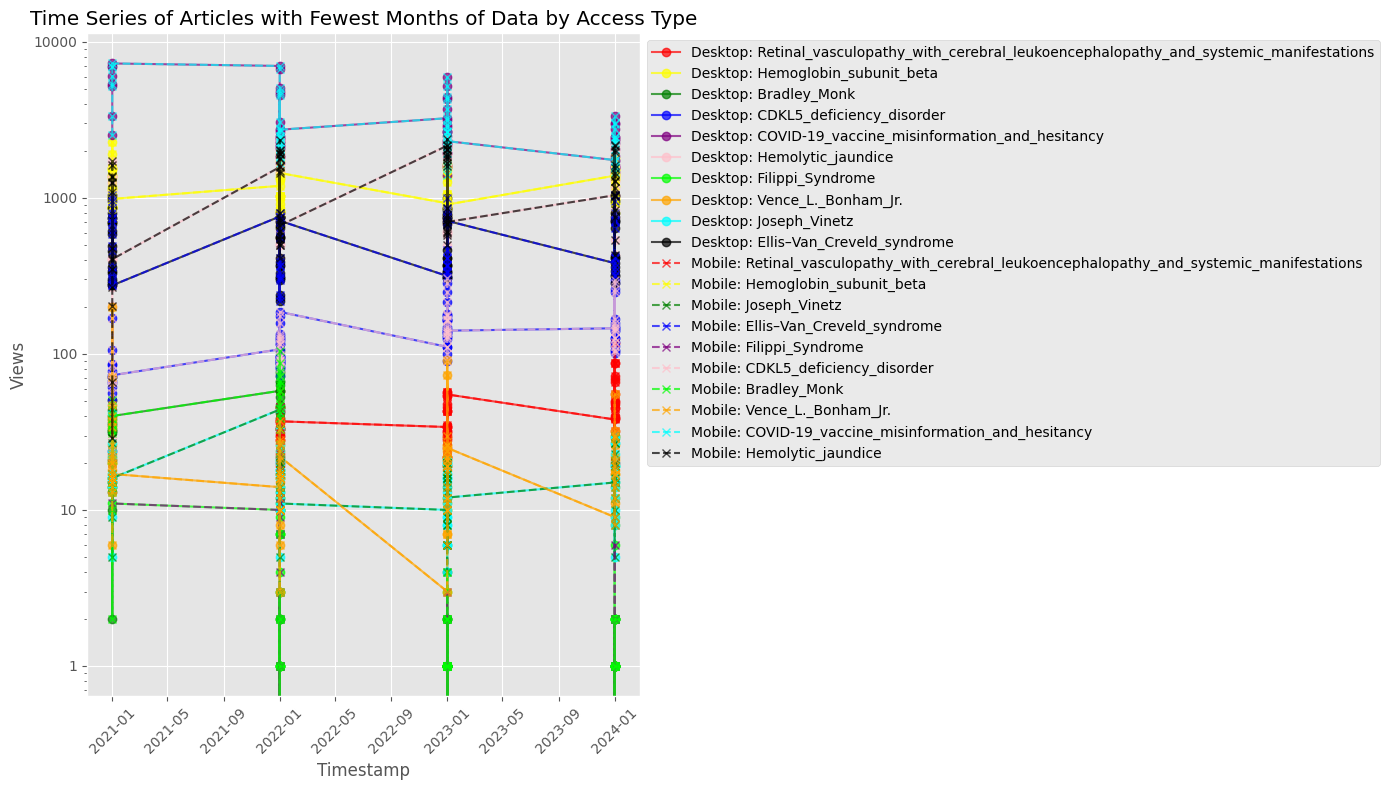

In [16]:
# Plot the data
fig, ax = plt.subplots(figsize=(14,8))

# Define a bunch of colors for use in plotting to differentiate lines. Redefine for clarity.
colors = [
    'red', 'yellow', 'green', 'blue', 'purple', 'pink', 'lime', 'orange', 'cyan', 'black',
]

for idx, article in enumerate(fewest_desktop_article):
    article_df = fewest_desktop_df.filter(pl.col('article') == article)
    ax.plot(
        article_df.select('timestamp'),
        article_df.select('views'),
        label=f'Desktop: {article}',
        color=colors[idx % len(colors)],
        linestyle='-',
        marker='o',
        alpha=0.7
    )

# Plot mobile articles
for idx, article in enumerate(fewest_mobile_article):
    article_df = fewest_mobile_df.filter(pl.col('article') == article)
    ax.plot(
        article_df.select('timestamp'),
        article_df.select('views'),
        label=f'Mobile: {article}',
        color=colors[(idx + 10) % len(colors)],
        linestyle='--',
        marker='x',
        alpha=0.7
    )


ax.set_title('Time Series of Articles with Fewest Months of Data by Access Type')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Views')
ax.set_yscale('log')  # set the y-axis to log scale to better visualize wide range of views data.
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.tick_params(axis='x', rotation=45)


# Remove the scientific notation y-axis.
ax.get_yaxis().set_major_formatter(mticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='y')

fig.tight_layout()
fig.savefig('fewest_months_articles.png')
plt.show()